# **Inteligencia Artificial y Aprendizaje Automático**
## **Maestría en Inteligencia Artificial Aplicada**
### **Dr Luis Eduardo Falcón Morales**
### **Tecnológico de Monterrey**
## **Actividad Individual Semana 9: Pronósticos con Series de Tiempo**


#### **Nombre:** Oscar Luis Guadarrama Jimenez  
#### **Matrícula:** A01796245


In [1150]:
## ++++++++++ Incluye todas las celdas y líneas de código que requieras +++++++++++++++++++++++++

**Librerias** 

In [1277]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import math

from prophet import Prophet
import tensorflow as tf
import keras
from keras import Sequential
from keras import layers
from keras.layers import LSTM, Dense
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.arima.model import ARIMA

from tensorflow.keras.callbacks import EarlyStopping

**Preparacion de los datos**

In [1278]:

df = pd.read_csv("monthly_champagne_sales.csv") # Carga del dataset en un df
df.head()

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


In [1279]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Month   105 non-null    object
 1   Sales   105 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ KB


In [1280]:
df.columns = ['ds', 'y']  # Renombramos las columnas de fecha y ventas 
df['ds'] = pd.to_datetime(df['ds']) #Tranformasmos la fecha a tipo datetime
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      105 non-null    datetime64[ns]
 1   y       105 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.8 KB
None
          ds     y
0 1964-01-01  2815
1 1964-02-01  2672
2 1964-03-01  2755
3 1964-04-01  2721
4 1964-05-01  2946


In [1283]:
df_temp = df.copy() # Cremaos una copia del df
df_temp.set_index('ds', inplace=True) # Configurar la columna de fecha como índice para análisis de series temporales
df_temp.head()

,y
ds,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [1286]:
print(df.shape)
print(df_temp.shape)

(105, 2)
(105, 1)


In [1287]:
df_temp.index # Observamos que aquí todavía no se tiene información del argumento "freq"

DatetimeIndex(['1964-01-01', '1964-02-01', '1964-03-01', '1964-04-01',
               '1964-05-01', '1964-06-01', '1964-07-01', '1964-08-01',
               '1964-09-01', '1964-10-01',
               ...
               '1971-12-01', '1972-01-01', '1972-02-01', '1972-03-01',
               '1972-04-01', '1972-05-01', '1972-06-01', '1972-07-01',
               '1972-08-01', '1972-09-01'],
              dtype='datetime64[ns]', name='ds', length=105, freq=None)

In [1288]:
df_temp.index.freq = 'MS' # Definir la frecuencia de los datos como mensual (MS = Month Start)
df_temp.index

DatetimeIndex(['1964-01-01', '1964-02-01', '1964-03-01', '1964-04-01',
               '1964-05-01', '1964-06-01', '1964-07-01', '1964-08-01',
               '1964-09-01', '1964-10-01',
               ...
               '1971-12-01', '1972-01-01', '1972-02-01', '1972-03-01',
               '1972-04-01', '1972-05-01', '1972-06-01', '1972-07-01',
               '1972-08-01', '1972-09-01'],
              dtype='datetime64[ns]', name='ds', length=105, freq='MS')

In [1289]:
# Particionemos en entrenamiento y prueba como DataFrames de Pandas:

train = df_temp.iloc[0:-12,:]
test = df_temp.iloc[-12:,:]


print(train.shape)
print(test.shape)

(93, 1)
(12, 1)


In [1290]:
# División del dataset en entrenamiento y prueba
#    - Entrenamiento: Datos hasta septiembre de 1971
#    - Prueba: Últimos 12 meses (octubre 1971 - septiembre 1972)
print("Período de entrenamiento:")
print(train.index)
print("Período de prueba:")
print(test.index)

Período de entrenamiento:
DatetimeIndex(['1964-01-01', '1964-02-01', '1964-03-01', '1964-04-01',
               '1964-05-01', '1964-06-01', '1964-07-01', '1964-08-01',
               '1964-09-01', '1964-10-01', '1964-11-01', '1964-12-01',
               '1965-01-01', '1965-02-01', '1965-03-01', '1965-04-01',
               '1965-05-01', '1965-06-01', '1965-07-01', '1965-08-01',
               '1965-09-01', '1965-10-01', '1965-11-01', '1965-12-01',
               '1966-01-01', '1966-02-01', '1966-03-01', '1966-04-01',
               '1966-05-01', '1966-06-01', '1966-07-01', '1966-08-01',
               '1966-09-01', '1966-10-01', '1966-11-01', '1966-12-01',
               '1967-01-01', '1967-02-01', '1967-03-01', '1967-04-01',
               '1967-05-01', '1967-06-01', '1967-07-01', '1967-08-01',
               '1967-09-01', '1967-10-01', '1967-11-01', '1967-12-01',
               '1968-01-01', '1968-02-01', '1968-03-01', '1968-04-01',
               '1968-05-01', '1968-06-01', '1968-07

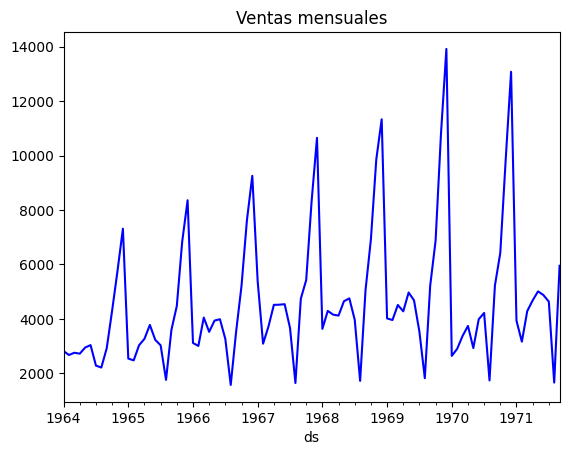

In [1291]:
# Gráfico con la periodicidad mensual:
train['y'].plot(title='Ventas mensuales', style='-b')
plt.show()

# **Modelo ingenuo**

In [1294]:
history = [x for x in train['y'].values]   # Definimos "history" donde de manera incremental se irán agregando registros mensuales.
predictions = list()    # Lista que contendrá las predicciones del modelo ingenuo.

for i in range(len(test['y'])):
  # Obtenemos las predicciones:
  yhat = history[-1]   # La primera vez, tomamos el último dato del Train, en las siguientes, se van agregando los datos de Test.
  predictions.append(yhat)

  # Observaciones-registros reales:
  obs = test.iloc[i]['y']   # Ahora vamos tomando los datos de Test.
  history.append(obs)  # Vamos agregando a "history" (que ya tiene todo los de Train) en cada iteración, un dato más de los de Test.
  print('>Esperado-real = %3d, Predicción = %.3f' % (obs, yhat))


# Calculamos la raíz del error cuadrático medio (RMSE):
rmse = np.sqrt(mean_squared_error(test['y'].values, predictions))
print('\nError-Modelo-Naive: RMSE: %.3f' % rmse)

>Esperado-real = 6981, Predicción = 5951.000
>Esperado-real = 9851, Predicción = 6981.000
>Esperado-real = 12670, Predicción = 9851.000
>Esperado-real = 4348, Predicción = 12670.000
>Esperado-real = 3564, Predicción = 4348.000
>Esperado-real = 4577, Predicción = 3564.000
>Esperado-real = 4788, Predicción = 4577.000
>Esperado-real = 4618, Predicción = 4788.000
>Esperado-real = 5312, Predicción = 4618.000
>Esperado-real = 4298, Predicción = 5312.000
>Esperado-real = 1413, Predicción = 4298.000
>Esperado-real = 5877, Predicción = 1413.000

Error-Modelo-Naive: RMSE: 3135.480


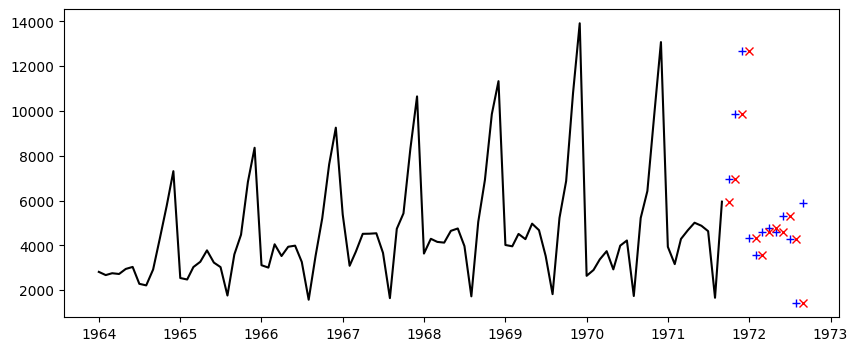

In [1295]:
fig, ax = plt.subplots(figsize=(10, 4))
ax = plt.plot(train['y'], '-k')  # Datos de entrenamiento de Enero-1964 a Septimbre-1971 (los históricos).
ax = plt.plot(test['y'], '+b')    # Datos de prueba reales del mes de Octubre 1971 a el mes de Septimbre-1972
ax = plt.plot(test.index, predictions, 'xr')  # Predicciones del modelo ingenuo para el mes de Octubre 1971 a el mes de Septimbre-1972

# **Modelo ARIMA**

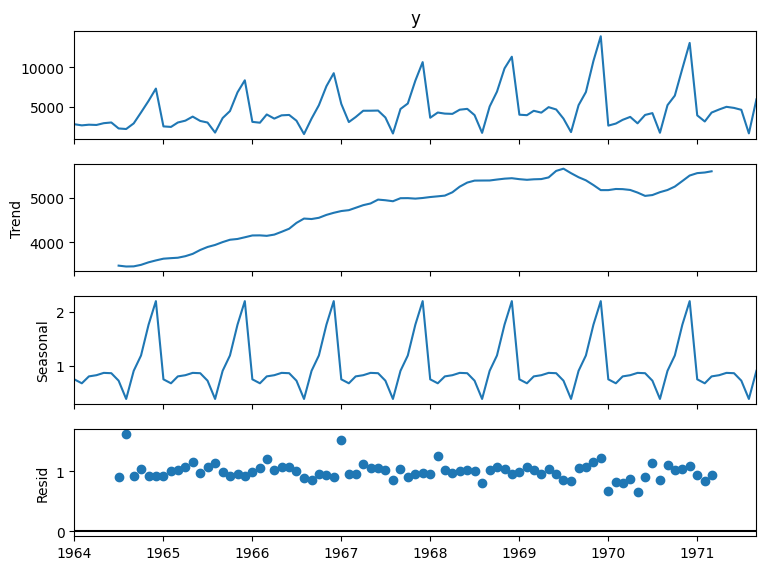

In [1296]:
decomposition = seasonal_decompose(train['y'].resample('MS').mean(), model='multiplicative') 
fig = decomposition.plot()
fig.set_size_inches(8,6)
plt.show()

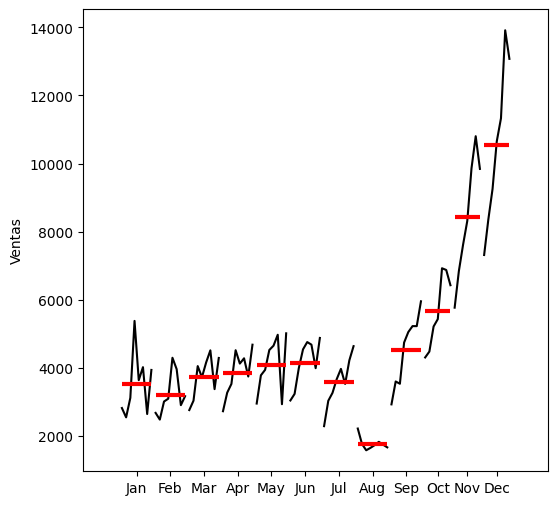

In [1299]:
# Gráfica para detección de estacionalidad mensual:
fig = month_plot(train['y'].resample('MS').mean(), ylabel='Ventas')
fig.set_size_inches(6,6)
plt.show()

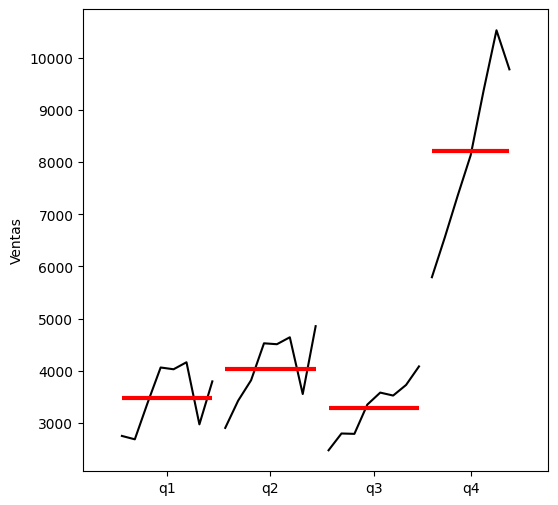

In [1300]:
# Si queremos graficar y detectar estacionalidad trimestral:
fig = quarter_plot(train['y'].resample('QS').mean(), ylabel='Ventas')
fig.set_size_inches(6,6)
plt.show()

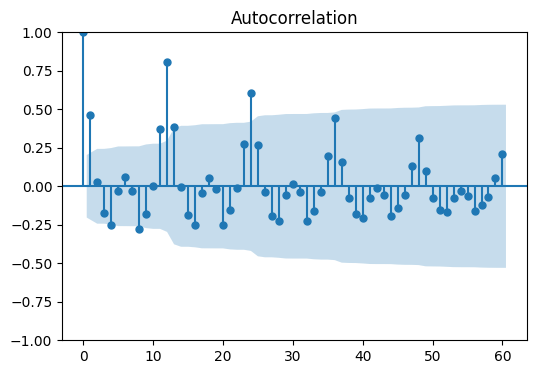

In [1301]:
# Gráfico de Autocorrelación (ACF: Auto-Correlation-Function)
fig,ax = plt.subplots(figsize = (6,4))
plot_acf(train['y'], lags=60, ax=ax)  
plt.show() 

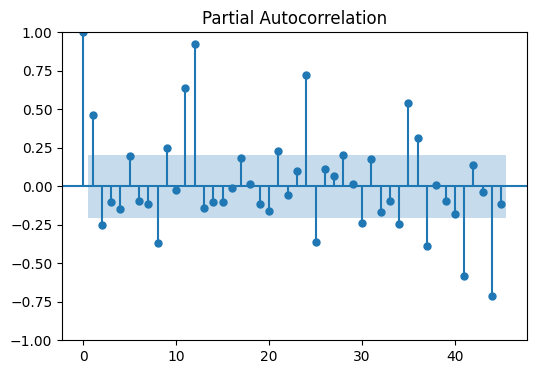

In [1302]:
fig, ax = plt.subplots(figsize = (6,4))
plot_pacf(train['y'], lags = 45, ax = ax, method="ols")   # ols: regression of time series on lags of it an on constant. predetrminado method="ywm"
plt.show()

In [1303]:
# Lo primero es para quitar la estacionalidad y transformar un problema
# de tipo no-estacionario (SARIMA) en uno estacionario (ARIMA):

# Diferencia de datos consecutivos en el tiempo
# y podemos ahora usar ARIMA:
def difference(dataset, interval=1):
  diff = list()

  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)

  return np.array(diff)



# Invierte las diferencias anteriores, es decir, nos regresa la estacionalidad:
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]


In [1358]:
# Definamos la siguiente lista de registros de pasajeros en el tiempo:
history = [x for x in train.loc[:,'y'].values]   # train-ndarray : columna solo con los registros de ventas "y".
                               # history-list : lista con los datos del train.

predictions = list()   # Para incluir las predicciones que vaya generando el modelo.

for i in range(len(test['y'])):
  #
  months_in_year = 12
  diff = difference(history, months_in_year)    # diff-list: lista de los datos de diferencias para transformar SARIMA en ARIMA.

  # Generamos el modelo.
  model = ARIMA(diff, order=(3,0,4),) # Si aplicamos diff, entonces d=0 es aplicable.
  model_fit = model.fit(method_kwargs={'maxiter':300})  # Aumentar las iteraciones para evitar el WarningConvergence.

  yhat = model_fit.forecast()[0]   # prediccions (yhat) de cada registro, es un solo número flotante.
  yhat = inverse_difference(history, yhat, months_in_year)    # El "history" sigue siendo la lista de arriba.
                                                              # El nuevo "yhat" es cada un nuevo valor (float) de predicción.
  predictions.append(yhat)  # predictions-list : lista que se va incrementando al ir agregando cada predicción nueva.

  # Observaciones-reales:
  obs = test.iloc[i]['y']   #  cada dato es un flotante.
  history.append(obs)   #  history-list : se va incrementado a partir del Train con los registros-observaciones reales.

  print('>Esperado-real = %3d, Predicción = %.3f' % (obs, yhat))

# Error RMSE:
rmse = np.sqrt(mean_squared_error(test['y'].values, predictions))
print('\nError-Modelo-ARIMA: RMSE: %.3f' % rmse)

>Esperado-real = 6981, Predicción = 6746.583
>Esperado-real = 9851, Predicción = 9945.443
>Esperado-real = 12670, Predicción = 13375.582
>Esperado-real = 4348, Predicción = 4370.033
>Esperado-real = 3564, Predicción = 3537.084
>Esperado-real = 4577, Predicción = 4393.849
>Esperado-real = 4788, Predicción = 4855.487
>Esperado-real = 4618, Predicción = 5385.615
>Esperado-real = 5312, Predicción = 5337.608
>Esperado-real = 4298, Predicción = 4840.941
>Esperado-real = 1413, Predicción = 1601.907
>Esperado-real = 5877, Predicción = 6004.993

Error-Modelo-ARIMA: RMSE: 357.977


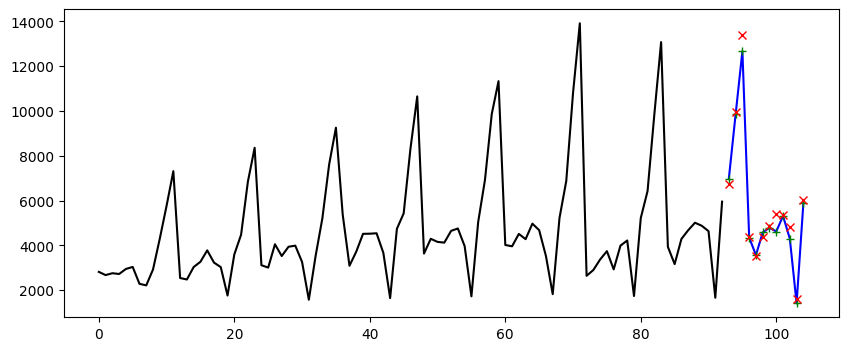

In [1359]:
# Veamos su gráfico:
fig, ax = plt.subplots(figsize=(10, 4))
ax = plt.plot(train['y'], '-k')
ax = plt.plot(test['y'], '-b')
ax = plt.plot(test['y'], '+g')
ax = plt.plot(test.index, predictions, 'xr')

# **Facebook-Meta-Prophet**

In [1360]:
train = df.iloc[0:-12,:]
test = df.iloc[-12:,:]

In [1361]:
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=True,
                changepoint_prior_scale=0.2,   
                seasonality_prior_scale=0.1)   

model.fit(train)

14:19:30 - cmdstanpy - INFO - Chain [1] start processing
14:19:30 - cmdstanpy - INFO - Chain [1] done processing


In [1362]:
pred_FP = model.predict(test)['yhat']
rmse = np.sqrt(mean_squared_error(test['y'], pred_FP))
print('\nError-Modelo-FacebookProphet: RMSE: %.3f' % rmse)


Error-Modelo-FacebookProphet: RMSE: 327.802


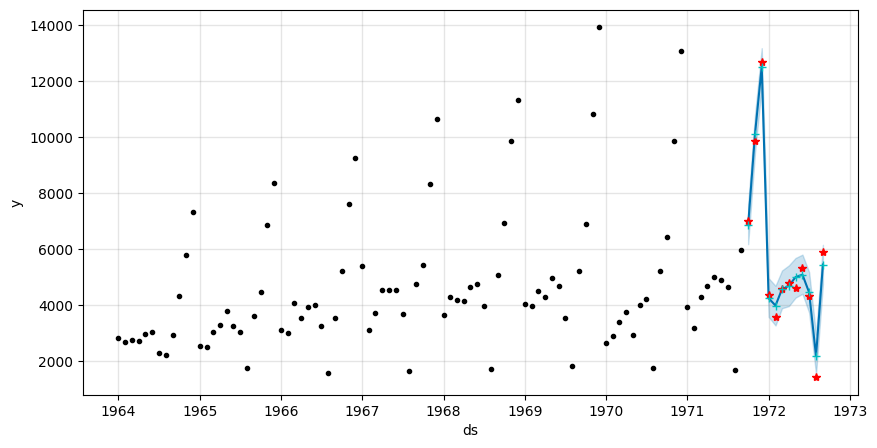

In [1363]:
forecast = model.predict(test)

fig, ax = plt.subplots(figsize=(10, 5))
model.plot(forecast, ax=ax)               # Las predicciones se muestran con la línea continua, junto con su región de variabilidad de la predicción.
ax = plt.plot(test['ds'], test['y'], '*r')   # Agregamos los datos de prueba (Test) con puntos rojos, para observar la diferencia.
ax = plt.plot(test['ds'], forecast['yhat'], '+c')    # Valores reales.

# **Long Short Term Memory (LSTM)**

In [1390]:
def creamos_secuencias(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])  # Ventana en este ejercicio de 12 meses de manera continua
        y.append(data[i])  # y el siguiente mes a predecir, dados los 12 anteriores.
    return np.array(X), np.array(y)

In [1393]:
# Tamaño de la ventana, para este ejercicio de la aerolínea estamos
# considerando 12 meses:

window_size = 12

# Creamos las secuencias de entrenamiento
X, y = creamos_secuencias(df_temp[['y']].values, window_size)

print(X.shape)  # verifiquemos que el formato es el requerido por la CNN.

(93, 12, 1)


In [1394]:
# Dividimos los datos en Entrenamiento y Prueba:
split = int(0.85 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(X_train.shape)   # (secuencias, tamaño_secuencia, variables)
print(X_test.shape)  

(79, 12, 1)
(14, 12, 1)


In [1473]:
# Construimos un modelo secuencial relativamente simple basado en LSTMs:
early_stop = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)


model = Sequential()
model.add(LSTM(250,  # total de neuronas de la capa LSTM
               return_sequences=True, # para que siga manteniendo el formato de 3 dimensiones.
               activation='relu',
               recurrent_activation='sigmoid'
               ))  # Capa LSTM
model.add(LSTM(150, return_sequences=True, activation='relu'))
model.add(LSTM(250, return_sequences=False, activation='relu'))
model.add(Dense(1))  # Capa de salida

# Compilamos el modelo
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.RootMeanSquaredError()],   #  despliega RMSE
              )

# y llevamos a cabo el entrenamiento con los cunjuntos de entrenamiento y prueba:
history = model.fit(X_train, y_train, epochs=500, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 25243268.0000 - root_mean_squared_error: 5016.4722 - val_loss: 27450052.0000 - val_root_mean_squared_error: 5239.2798
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 20566574.0000 - root_mean_squared_error: 4527.1289 - val_loss: 20068910.0000 - val_root_mean_squared_error: 4479.8335
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 14289481.0000 - root_mean_squared_error: 3771.8142 - val_loss: 12945227.0000 - val_root_mean_squared_error: 3597.9475
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7013778.5000 - root_mean_squared_error: 2635.2957 - val_loss: 8459415.0000 - val_root_mean_squared_error: 2908.5073
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6625406.5000 - root_mean_squared_error: 2565.0254 - val_loss: 19262902.0000 - val_root_mean_squared_error: 4388.9521
Epoch 6/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7460715.5000 - root_mean_squared_error: 2730.9033 - val_loss: 125

In [1474]:
pred_LSTM = model.predict(X_test[-12:])
y_test_real = y_test[-12:].reshape(-1, 1)

# Calculamos el RMSE en la escala original de los datos:
rmse = np.sqrt(mean_squared_error(y_test_real, pred_LSTM))
print('\nError-Modelo-LSTM: RMSE: %.3f' % rmse)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step

Error-Modelo-LSTM: RMSE: 309.904


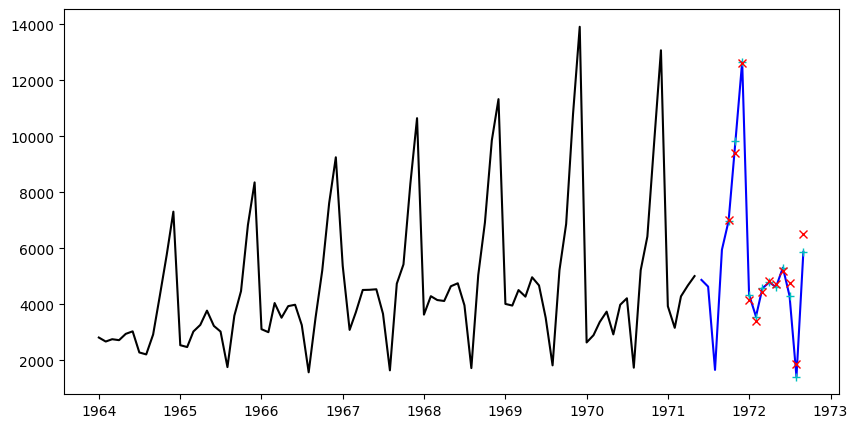

In [1477]:
# Grafiquemos los resultados:

fig, ax = plt.subplots(figsize=(10, 5))
ax = plt.plot(df['ds'][0:int(0.85 * len(df))], df['y'][0:int(0.85 * len(df))], '-k')  # Datos de entrenamiento de Enero-1964 a Septimbre-1971 (los históricos).
ax = plt.plot(df['ds'][int(0.85 * len(df)):], df['y'][int(0.85 * len(df)):], '-b')    # Datos de prueba reales del mes de Octubre 1971 a el mes de Septimbre-1972
ax = plt.plot(df['ds'][-12:], df['y'][-12:], '+c')    # Datos de prueba incluyendo solo los puntuales reales del mes de Octubre 1971 a el mes de Septimbre-1972
ax = plt.plot(df['ds'][-12:], pred_LSTM, 'xr')  # Predicciones puntuales del modelo del mes de Octubre 1971 a el mes de Septimbre-1972

#  **Conclusiones**

En esta práctica, hemos comparado distintos modelos de predicción de series temporales para estimar las ventas mensuales, analizando sus diferencias en rendimiento y precisión. Inicialmente, el modelo ingenuo mostró un alto error (RMSE = 3135.489), evidenciando la necesidad de enfoques más avanzados. ARIMA mejoró significativamente la predicción (RMSE = 357.977), capturando bien la estacionalidad, aunque con ciertas limitaciones ante cambios bruscos en la serie. Facebook Prophet, tras varias optimizaciones, logró reducir aún más el error (RMSE = 327.802), demostrando su capacidad de modelar tendencias y estacionalidad de manera flexible. Finalmente, el modelo LSTM fue el más preciso (RMSE = 309.904), mejorando la predicción al captar patrones complejos en los datos. Sin embargo, su rendimiento depende fuertemente del volumen de datos y del ajuste fino de hiperparámetros. En conclusión, mientras que ARIMA y Prophet ofrecen interpretabilidad y son adecuados para tendencias bien definidas, LSTM mostró un mayor potencial de predicción, aunque con mayor requerimiento computacional. 

## **<<< Fin de la Actividad de la Semana - Pronósticos y Series de Tiempo >>>**